In [ ]:
##### import stuff we need!
import pandas as pd
import re
## https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
## its maybe better to use TfidVectorizer than PCA for text? https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [8]:
# Load the dataset
recipes_path = "./data/recipes.json"
recipes_df = pd.read_json(recipes_path)

# main ingredients based on quick excel analysis
ingredients_list = [
    "açaí", "achiote", "acini di pepe", "almond butter", "almonds",
    "anchovies", "apples", "apricots", "artichoke", "avocados", "bacon",
    "bananas", "basil", "bay leaves", "beans", "beef", "bell pepper",
    "berry", "blackberries", "bread", "broccoli", "broth", "bulgur wheat", "butter",
    "cabbage", "capers", "caramel", "carrots", "cashews", "catfish", "cauliflower",
    "celery", "cereal", "cheese", "cherries", "chicken", "chickpeas", "chili", "chive",
    "chocolate", "cilantro", "clams", "cocoa", "coconut", "cod", "corn", "cornstarch",
    "crab", "cranberries", "cucumber", "dill", "eggplant", "eggs",
    "fennel", "figs", "fish", "flaxseed", "flounder", "flour", "frosting",
    "garlic", "ginger", "gnocchi", "green beans", "halibut", "ham", "herring", "honey",
    "hot sauce", "jalapeños", "kale", "ketchup", "kimchi", "salt", "lamb",
    "leek", "lemon", "lettuce", "limes", "macaroni", "mackerel", "maple syrup",
    "mayonnaise", "milk", "mushrooms", "mustard", "noodles", "oats", "olive", "olive oil",
    "onion", "orzo", "oyster sauce", "parsley", "peanut butter", "pears", "peas", "pickles",
    "pineapple", "pineapple juice", "pork", "potato", "pumpkin", "quinoa", "red pepper flakes",
    "rice", "rosemary", "sage", "salmon", "salsa", "sardines", "sausage", "scallions", "scallops",
    "seafood", "sesame oil", "sesame seeds", "shrimp", "snapper", "soy sauce", "spaghetti", "spices",
    "spinach", "squash", "strawberry", "sugar", "sweet potatoes", "swordfish", "tahini", "tilapia",
    "tofu", "tomato", "tortillas", "trout", "tuna", "turkey", "vinegar", "wontons", "yams", "yogurt",
    "zucchini"
]

# clean ingredient names 
recipes_df['ingredients'] = recipes_df['ingredients'].apply(lambda x: [ingredient.strip().lower() for ingredient in x])

# make ingredients matrix df
#start with all zeros
ingredient_df = pd.DataFrame(0, index=recipes_df.index, columns=ingredients_list)
ingredient_df['id'] = recipes_df['id']


# Function to match ingredients and assign 1s ## got help from chatgpt for this one to get partial matches
def match_ingredients(recipe_idx, recipe_ingredients, ingredient_columns):
    for column in ingredient_columns:
        if any(column in ingredient for ingredient in recipe_ingredients):
            ingredient_df.loc[recipe_idx, column] = 1

for idx, row in recipes_df.iterrows():
    match_ingredients(idx, row['ingredients'], ingredient_df.columns)

## export the csv of the matrix so we can look at it and confirm it worked
ingredient_df.to_csv('binary_ingredients_matrix.csv', index=False)


In [9]:

# convert ingredients column to a string
recipes_df['ingredients_string'] = recipes_df['ingredients'].apply(lambda x: ' '.join(x))

# use TfidfVectorizer to figure out which ingredients are the most important across all the recipes
# essentially it gives a weight to each ingredient so that later when we look at it it can decide if that ingredient should be taken into consideration for classification
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000) ## to ignore words like is https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
X = vectorizer.fit_transform(recipes_df['ingredients_string'])

# k-clustering
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
recipes_df['cuisine'] = kmeans.fit_predict(X)

# change numbers to letters -- for no reason other than later I will give them names rather than numbers so i want them to be strings
unique_labels = [chr(i) for i in range(65, 65 + n_clusters)]  
recipes_df['cuisine'] = recipes_df['cuisine'].map(lambda x: unique_labels[x])

In [ ]:
## go through each cluster and information on ingredients in those clusters 
# one way is to see which ingredient usually exists if one doesnt 
# second way is to look at nutritional value of item and replace it with

## all below is from chatgpt do not use

Index(['id', 'ingredients', 'ingredients_string', 'cuisine'], dtype='object')


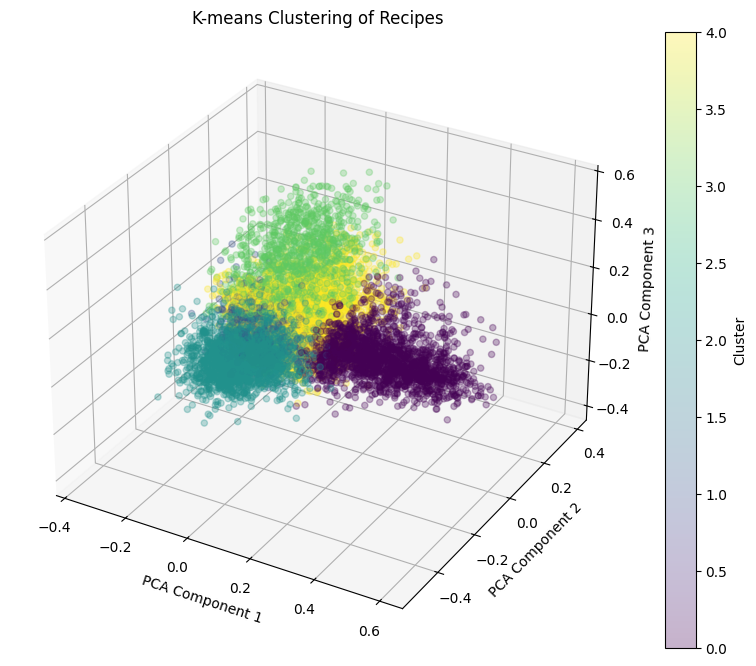

In [10]:
print(recipes_df.columns)

# PCA
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X.toarray()) 

# plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = X_pca[:, 0]
y = X_pca[:, 1]
z = X_pca[:, 2]

scatter = ax.scatter(x, y, z, c=recipes_df['cuisine'].map({label: i for i, label in enumerate(unique_labels)}),
                     cmap='viridis', marker='o', alpha=0.3)

ax.set_title("K-means Clustering of Recipes")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")


plt.colorbar(scatter, label='Cluster')
plt.show()

# Save csv to look at it
recipes_df.to_csv('recipes_with_clusters.csv', index=False)

In [11]:
# Get the indices of the most important features for each component (top 5 features per component)
import numpy as np

top_n = 5  # Get top 5 features for each component
for i in range(pca.components_.shape[0]):  # Iterate over each principal component
    component = pca.components_[i]
    top_features_idx = np.argsort(np.abs(component))[-top_n:]  # Get indices of top features
    print(f"Top {top_n} features for PCA component {i+1}:")
    for idx in top_features_idx:
        print(f"  {vectorizer.get_feature_names_out()[idx]} (weight: {component[idx]:.3f})")


Top 5 features for PCA component 1:
  eggs (weight: 0.203)
  purpose (weight: 0.209)
  pepper (weight: -0.224)
  flour (weight: 0.254)
  sugar (weight: 0.260)
Top 5 features for PCA component 2:
  rice (weight: -0.195)
  sesame (weight: -0.252)
  soy (weight: -0.300)
  sauce (weight: -0.336)
  cheese (weight: 0.340)
Top 5 features for PCA component 3:
  lemon (weight: -0.213)
  cream (weight: 0.217)
  shredded (weight: 0.225)
  fresh (weight: -0.229)
  cheese (weight: 0.305)
